In [72]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import label, center_of_mass
from sklearn.metrics import r2_score
import math
import matplotlib.pyplot as plt

from holodecml.data import load_raw_datasets, load_train_patches, load_train_patches_1to25


In [2]:
path_data = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/"
num_particles = [1,2,3,4,5,6,7,8,9,10,"12-25"]
output_cols = ["x", "y", "z", "d", "hid"]
subset = [500,500,500,500,500,500,500,500,500,500,6500]
scaler_out = MinMaxScaler()
rad = 64


In [3]:
def scale_images(images, scaler_in=None):
    """
    Takes in array of images and scales pixel values between 0 and 1
    
    Args: 
        images: (np array) Input image data
        scaler_in: (dict) Image scaler 'max' and 'min' values
        
    Returns:
        images_scaled: (np array) Input image data scaled between 0 and 1
        scaler_in: (dict) Image scaler 'max' and 'min' values
    """
    
    if scaler_in is None:
        scaler_in = {}
        scaler_in["min"] = images.min()
        scaler_in["max"] = images.max()
    images_scaled = (images.astype(np.float32) - scaler_in["min"])
    images_scaled /= (scaler_in["max"] - scaler_in["min"])

    return images_scaled, scaler_in

In [4]:
def load_pred_patches_1to25(path_preds, path_data, num_particles, output_cols,
                            scaler_out=False, subset=False, rad=False, threshold=0.3):
    
    '''Creates hologram patches centered around predicted particles.'''
    
    # load raw datasets    
    train_patches_all = []
    train_hids_all = []
    train_outputs_all = []
    valid_patches_all = []
    valid_hids_all = []
    valid_outputs_all = []
        
    idx_start = 0
    for num,sub in zip(num_particles, subset):
        train_inputs,\
        train_outputs = load_raw_datasets(path_data, num, 'train',
                                          output_cols, sub)
        valid_inputs,\
        valid_outputs = load_raw_datasets(path_data, num, 'valid',
                                          output_cols, sub//10)
        print(f"finished loading raw dataset for num_particles: {num}")

        # scale images
        train_inputs, scaler_in = scale_images(train_inputs)
        valid_inputs, _ = scale_images(valid_inputs, scaler_in)
        
        # use scipy.ndimage.label and scipy.ndimage.center_of_mass to extract predicted particles
        preds = xr.open_dataset(path_preds + "train_outputs_pred.nc").to_array()[0, :, :, :, 0]
        coms = []
        for pred in preds[idx_start:idx_start+sub]:
            holo_label, label_count = label(np.where(pred >= threshold, 1, 0))
            com = np.array(center_of_mass(pred, holo_label, np.arange(1, label_count+1)))
            coms.append(np.round(com).astype(int))
        print("Finished extracting coms from train preds")

        # calculate bin factor from inputs to the jnet model
        x_factor = train_inputs.shape[1] // preds.x.shape[0]
        y_factor = train_inputs.shape[2] // preds.y.shape[0]
    
        # exise patches from zero-padded holograms for training set
        train_patches = []
        train_x = []
        train_y = []
        train_hids = []
        for hid in train_outputs["hid"].unique().astype(int):
            input_hid = np.pad(train_inputs[hid-1], rad)
            com = coms[hid-1]
            for c in com:
                idx_x, idx_y = int(c[0]*x_factor)+rad, int(c[1]*y_factor)+rad            
                patch = input_hid[idx_x-rad:idx_x+rad+1, idx_y-rad:idx_y+rad+1]
                train_patches.append(patch)
                train_x.append(idx_x-rad)
                train_y.append(idx_y-rad)
                train_hids.append(hid)
        train_patches = np.stack(train_patches)
        train_x = np.array(train_x).reshape(-1,1)
        train_y = np.array(train_y).reshape(-1,1)
        train_hids = np.array(train_hids).reshape(-1,1)
        train_hids = np.hstack((train_hids, train_x, train_y))
        print("Finished extracting train patches")

        # use scipy.ndimage.label and scipy.ndimage.center_of_mass to extract predicted particles
        preds = xr.open_dataset(path_preds + "valid_outputs_pred.nc").to_array()[0, :, :, :, 0]
        coms = []
        for pred in preds:
            holo_label, label_count = label(np.where(pred >= threshold, 1, 0))
            com = np.array(center_of_mass(pred, holo_label, np.arange(1, label_count+1)))
            coms.append(np.round(com).astype(int))
        print("Finished extracting coms from valid preds")

        # calculate bin factor from inputs to the jnet model
        x_factor = valid_inputs.shape[1] // preds.x.shape[0]
        y_factor = valid_inputs.shape[2] // preds.y.shape[0]

        # exise patches from zero-padded holograms for validation set
        valid_patches = []
        valid_x = []
        valid_y = []
        valid_hids = []
        for hid in valid_outputs["hid"].unique().astype(int):
            input_hid = np.pad(valid_inputs[hid-1], rad)
            com = coms[hid-1]
            for c in com:
                idx_x, idx_y = int(c[0]*x_factor)+rad, int(c[1]*y_factor)+rad
                patch = input_hid[idx_x-rad:idx_x+rad+1, idx_y-rad:idx_y+rad+1]
                valid_patches.append(patch)
                valid_x.append(idx_x-rad)
                valid_y.append(idx_y-rad)
                valid_hids.append(hid)
        valid_patches = np.stack(valid_patches)
        valid_x = np.array(valid_x).reshape(-1,1)
        valid_y = np.array(valid_y).reshape(-1,1)
        valid_hids = np.array(valid_hids).reshape(-1,1)
        valid_hids = np.hstack((valid_hids, valid_x, valid_y))
        print("Finished extracting valid patches")
        
        train_patches_all.append(train_patches)
        train_hids_all.append(train_hids)
        train_outputs_all.append(train_outputs)
        valid_patches_all.append(valid_patches)
        valid_hids_all.append(valid_hids)
        valid_outputs_all.append(valid_outputs)
    
    train_patches_all = np.vstack(train_patches_all)
    train_hids_all = np.vstack(train_hids_all)
    train_outputs_all = np.vstack(train_outputs_all)
    valid_patches_all = np.vstack(valid_patches_all)
    valid_hids_all = np.vstack(valid_hids_all)
    valid_outputs_all = np.vstack(valid_outputs_all)
    
    train_outputs = train_outputs.drop(['hid'], axis=1)
    train_outputs = scaler_out.fit_transform(train_outputs)
    
    valid_outputs = valid_outputs.drop(['hid'], axis=1)
    valid_outputs = scaler_out.transform(valid_outputs)
    
    return train_patches, train_hids, train_outputs, valid_patches, valid_hids, valid_outputs


In [5]:
path_preds = "/glade/p/cisl/aiml/ggantos/holodec/unet/jnet_10_1to25/"

train_patches,\
train_patch_hids,\
train_patch_outputs,\
valid_patches,\
valid_patch_hids,\
valid_patch_outputs = load_pred_patches_1to25(path_preds,
                                        path_data,
                                        num_particles,
                                        output_cols,
                                        scaler_out,
                                        subset,
                                        rad)


finished loading raw dataset for num_particles: 1
Finished extracting coms from train preds
Finished extracting train patches
Finished extracting coms from valid preds
Finished extracting valid patches
finished loading raw dataset for num_particles: 2
Finished extracting coms from train preds
Finished extracting train patches
Finished extracting coms from valid preds
Finished extracting valid patches
finished loading raw dataset for num_particles: 3
Finished extracting coms from train preds
Finished extracting train patches
Finished extracting coms from valid preds
Finished extracting valid patches
finished loading raw dataset for num_particles: 4
Finished extracting coms from train preds
Finished extracting train patches
Finished extracting coms from valid preds
Finished extracting valid patches
finished loading raw dataset for num_particles: 5
Finished extracting coms from train preds
Finished extracting train patches
Finished extracting coms from valid preds
Finished extracting vali

In [6]:
path_model = "/glade/p/cisl/aiml/ggantos/holodec/jnet/zd/1to25_10_new/"
new_model = tf.keras.models.load_model(path_model + "cnn.h5")
new_model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 129, 129, 1)]     0         
_________________________________________________________________
conv2D_00 (Conv2D)           (None, 129, 129, 8)       208       
_________________________________________________________________
maxpool2D_00 (MaxPooling2D)  (None, 32, 32, 8)         0         
_________________________________________________________________
conv2D_01 (Conv2D)           (None, 32, 32, 16)        3216      
_________________________________________________________________
maxpool2D_01 (MaxPooling2D)  (None, 8, 8, 16)          0         
_________________________________________________________________
conv2D_02 (Conv2D)           (None, 8, 8, 32)          12832     
_________________________________________________________________
maxpool2D_02 (MaxPooling2D)  (None, 2, 2, 32)         

In [7]:
valid_patch_outputs_pred = new_model.predict(valid_patches)
valid_patch_outputs_pred


array([[0.55431616, 0.44568393],
       [0.5478844 , 0.45211557],
       [0.553453  , 0.44654703],
       ...,
       [0.5405204 , 0.4594796 ],
       [0.5485844 , 0.45141563],
       [0.5470055 , 0.45299456]], dtype=float32)

In [8]:
valid_patch_hids

array([[  1, 140,  50],
       [  2,  50, 250],
       [  3, 430,  80],
       ...,
       [650, 510, 390],
       [650, 550, 260],
       [650, 560,  70]])

In [20]:
valid_patch_outputs_pred

(3636, 2)

In [10]:
df_pred = np.hstack((valid_patch_hids, valid_patch_outputs_pred))
df_pred = pd.DataFrame(data=df_pred, columns=["hid", "x", "y", "z", "d"])
df_pred.head()

,hid,x,y,z,d
0,1.0,140.0,50.0,0.554316,0.445684
1,2.0,50.0,250.0,0.547884,0.452116
2,3.0,430.0,80.0,0.553453,0.446547
3,6.0,480.0,180.0,0.552744,0.447256
4,7.0,110.0,350.0,0.550235,0.449765


In [11]:
train_inputs,\
train_outputs,\
train_hids,\
valid_inputs,\
valid_outputs,\
valid_hids = load_train_patches_1to25(path_data,
                                         num_particles,
                                         output_cols,
                                         scaler_out,
                                         subset,
                                         rad)


In [58]:
df_true = np.hstack((valid_hids, valid_outputs))
df_true = pd.DataFrame(data=df_true, columns=["x", "y", "hid", "z", "d"])
df_true["z"] = MinMaxScaler().fit_transform(df_true["z"].values.reshape(-1, 1))
df_true["d"] = MinMaxScaler().fit_transform(df_true["d"].values.reshape(-1, 1))
df_true


,x,y,hid,z,d
0,0.058370,0.489981,1.0,0.234506,0.115869
1,0.382913,0.410304,2.0,0.073702,0.619647
2,0.951453,0.796795,3.0,0.723618,0.178841
3,0.273513,0.034688,4.0,0.051926,0.710327
4,0.453935,0.232921,5.0,0.901173,0.471033
...,...,...,...,...,...
147832,0.967876,0.258680,6500.0,0.991625,0.483627
147833,0.490013,0.521385,6500.0,0.760469,0.176322
147834,0.228768,0.380058,6500.0,0.187605,0.730479
147835,0.177232,0.262809,6500.0,0.649916,0.269521


In [59]:
loss_counts = []
loss_maxima = []
loss_zs = []
loss_ds = []
true_z = []
true_d = []

for hid in df_pred["hid"].unique().astype(int):
    df_true_hid = df_true.loc[df_true['hid'] == hid]
    df_pred_hid = df_pred.loc[df_pred['hid'] == hid]
    dist_x = (df_true_hid['x'].to_numpy() - df_pred_hid['x'].to_numpy()[:, np.newaxis]) ** 2
    dist_y = (df_true_hid['y'].to_numpy() - df_pred_hid['y'].to_numpy()[:, np.newaxis]) ** 2
    dist_z = (df_true_hid['z'].to_numpy() - df_pred_hid['z'].to_numpy()[:, np.newaxis]) ** 2
    dist_d = (df_true_hid['d'].to_numpy() - df_pred_hid['d'].to_numpy()[:, np.newaxis]) ** 2
    dist_xy = dist_x + dist_y
    matches = np.argmin(dist_xy, axis=1)
    loss_counts.append((df_true_hid.shape[0] - df_pred_hid.shape[0]) ** 2)
    loss_maxima.append(df_true_hid.shape[0] - df_pred_hid.shape[0])
    loss_zs.append(np.sum(dist_z[(np.arange(dist_z.shape[0]), matches)]))
    loss_ds.append(np.sum(dist_d[(np.arange(dist_d.shape[0]), matches)]))
    true_z.append(df_true_hid["z"].to_numpy()[matches])
    true_d.append(df_true_hid["d"].to_numpy()[matches])
loss_count = math.sqrt(sum(loss_counts))
loss_max = max(loss_maxima)
loss_z = math.sqrt(sum(loss_zs))
loss_d = math.sqrt(sum(loss_ds))
true_z = np.hstack(true_z)
true_d = np.hstack(true_d)

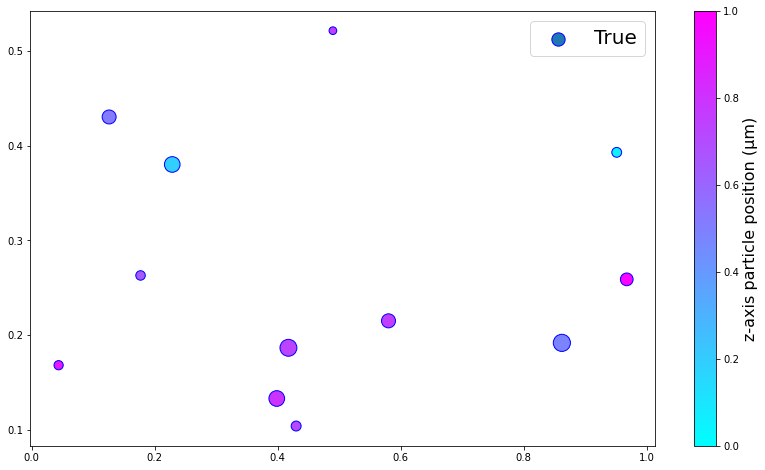

In [64]:
h = 6500
print()
plt.figure(figsize=(14, 8))
plt.scatter(df_true.loc[df_true['hid'] == h, "x"],
            df_true.loc[df_true['hid'] == h, "y"],
            df_true.loc[df_true['hid'] == h, "d"]*335,
            df_true.loc[df_true['hid'] == h, "z"],
            edgecolors="blue",
            vmin=df_true["z"].min(),
            vmax=df_true["z"].max(),
            cmap="cool",
            label="True",
            zorder=2)
# plt.scatter(df_pred.loc[df_pred['hid'] == h/10, "x"],
#             df_pred.loc[df_pred['hid'] == h/10, "y"],
#             df_pred.loc[df_pred['hid'] == h/10, "d"] *335,
#             df_pred.loc[df_pred['hid'] == h/10, "z"],
#             edgecolors="magenta",
#             vmin=df_pred["z"].min(),
#             vmax=df_pred["z"].max(),
#             cmap="cool",
#             label="Predicted",
#             zorder=1,
#             alpha=0.5)
plt.colorbar().set_label(label="z-axis particle position (µm)", size=16)
plt.legend(fontsize=20)
plt.show()

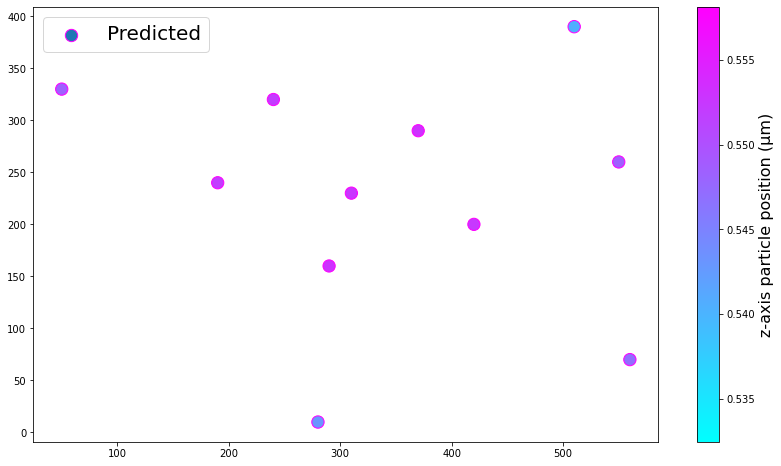

In [65]:
h = 6500
print()
plt.figure(figsize=(14, 8))
# plt.scatter(df_true.loc[df_true['hid'] == h, "x"],
#             df_true.loc[df_true['hid'] == h, "y"],
#             df_true.loc[df_true['hid'] == h, "d"]*2,
#             df_true.loc[df_true['hid'] == h, "z"],
#             edgecolors="blue",
#             vmin=df_true["z"].min(),
#             vmax=df_true["z"].max(),
#             cmap="cool",
#             label="True",
#             zorder=2)
plt.scatter(df_pred.loc[df_pred['hid'] == h/10, "x"],
            df_pred.loc[df_pred['hid'] == h/10, "y"],
            df_pred.loc[df_pred['hid'] == h/10, "d"] *335,
            df_pred.loc[df_pred['hid'] == h/10, "z"],
            edgecolors="magenta",
            vmin=df_pred["z"].min(),
            vmax=df_pred["z"].max(),
            cmap="cool",
            label="Predicted",
            zorder=1)
plt.colorbar().set_label(label="z-axis particle position (µm)", size=16)
plt.legend(fontsize=20)
plt.show()

r-squared = -0.030


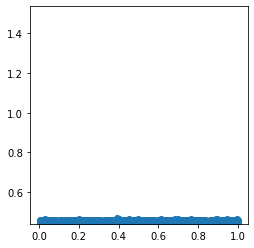

In [66]:
plt.scatter(true_d, df_pred["d"])
print("r-squared = {:.3f}".format(r2_score(true_d, df_pred["d"])))
plt.axis('square')
plt.show()


In [67]:
df_pred["z"].max()

0.5581222176551819

In [68]:
df_true["z"].max()

1.0

r-squared = -0.049


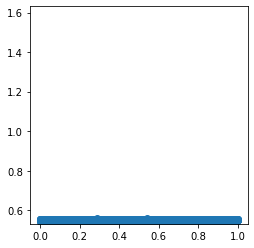

In [69]:
plt.scatter(true_z, df_pred["z"])
print("r-squared = {:.3f}".format(r2_score(true_z, df_pred["z"])))
plt.axis('square')
plt.show()


In [70]:
print(loss_count)
print(loss_max)
print(loss_z)
print(loss_d)


1515.7140231587223
79
17.98492897063152
17.731035312163407


In [71]:
df_true

,x,y,hid,z,d
0,0.058370,0.489981,1.0,0.234506,0.115869
1,0.382913,0.410304,2.0,0.073702,0.619647
2,0.951453,0.796795,3.0,0.723618,0.178841
3,0.273513,0.034688,4.0,0.051926,0.710327
4,0.453935,0.232921,5.0,0.901173,0.471033
...,...,...,...,...,...
147832,0.967876,0.258680,6500.0,0.991625,0.483627
147833,0.490013,0.521385,6500.0,0.760469,0.176322
147834,0.228768,0.380058,6500.0,0.187605,0.730479
147835,0.177232,0.262809,6500.0,0.649916,0.269521


(array([14769., 15090., 14826., 14618., 14805., 14747., 14315., 14948.,
        14774., 14945.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

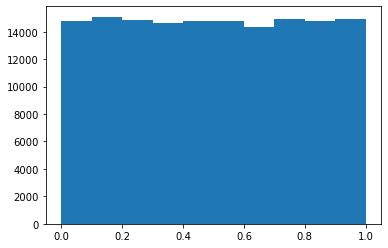

In [75]:
plt.hist(df_true["d"].values)

(array([15027., 14789., 14719., 14595., 14959., 14792., 14599., 14683.,
        14940., 14734.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

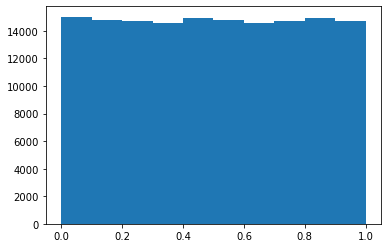

In [76]:
plt.hist(df_true["z"].values)

(array([  88.,  907., 1596.,  413.,  102.,  271.,  148.,   98.,    9.,
           4.]),
 array([0.44187775, 0.44444438, 0.44701101, 0.44957763, 0.45214426,
        0.45471089, 0.45727751, 0.45984414, 0.46241077, 0.46497739,
        0.46754402]),
 <BarContainer object of 10 artists>)

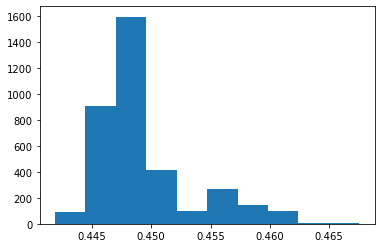

In [77]:
plt.hist(df_pred["d"].values)

(array([   4.,    9.,   98.,  148.,  271.,  102.,  413., 1596.,  907.,
          88.]),
 array([0.53245598, 0.5350226 , 0.53758923, 0.54015585, 0.54272248,
        0.5452891 , 0.54785572, 0.55042235, 0.55298897, 0.55555559,
        0.55812222]),
 <BarContainer object of 10 artists>)

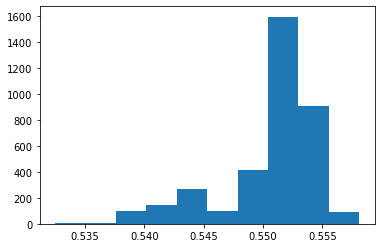

In [78]:
plt.hist(df_pred["z"].values)